2025-04-28 15:48:51,548 - INFO - Loaded data from data\test.xlsx with 1436 records
2025-04-28 15:48:51,549 - INFO - Enriching IP data...
2025-04-28 15:48:51,782 - INFO - IP enrichment completed
2025-04-28 15:48:51,783 - INFO - Enriching User-Agent data...
2025-04-28 15:48:52,025 - INFO - User-Agent enrichment completed
2025-04-28 15:48:52,027 - INFO - Found 1 accounts linked by device ID
2025-04-28 15:48:52,028 - INFO - Found 5 accounts linked by device fingerprint
2025-04-28 15:48:52,038 - INFO - Found 3 accounts linked by IP
2025-04-28 15:48:52,041 - WARNING - Compromised user's city is missing


Related Accounts:
by_device_id: ['00064120f0aa15e8c4197cf9f18a03a6e4bd35cb']
by_device_fingerprint: ['0007f265568f1abc1da791e852877df2047b3af9', '00010fb5147e6ec14e287ca903cd427339893450', 'e7190874862efef8d3acd53baba84bc54f29d111', '00064120f0aa15e8c4197cf9f18a03a6e4bd35cb', '0009e8252e8ffcb665b34c3dea1baee477fde74e']
by_ip: ['0007f265568f1abc1da791e852877df2047b3af9', 'e7190874862efef8d3acd53baba84bc54f29d111', '0004dcae0b5342c42c060fa0bde43c087ff728b7']
by_location: []


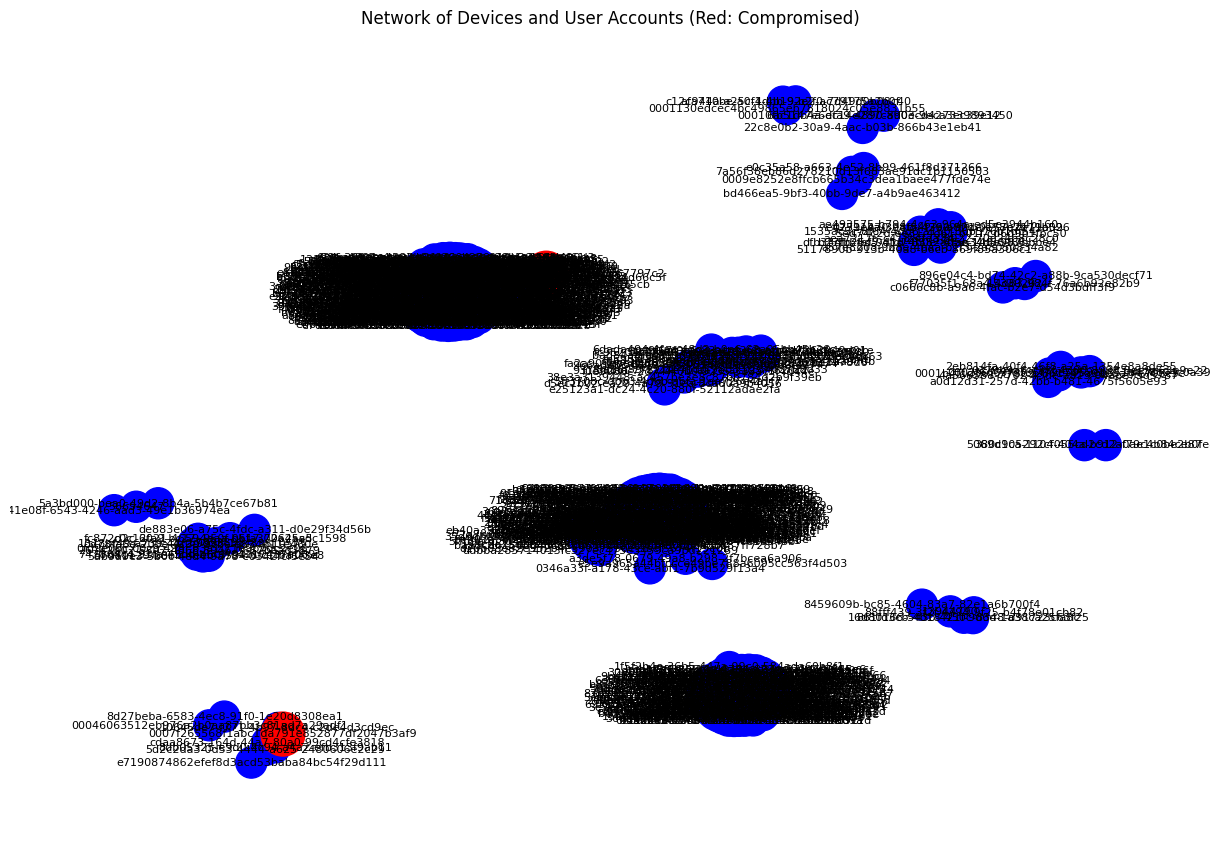

2025-04-28 15:48:56,630 - INFO - Network visualization saved


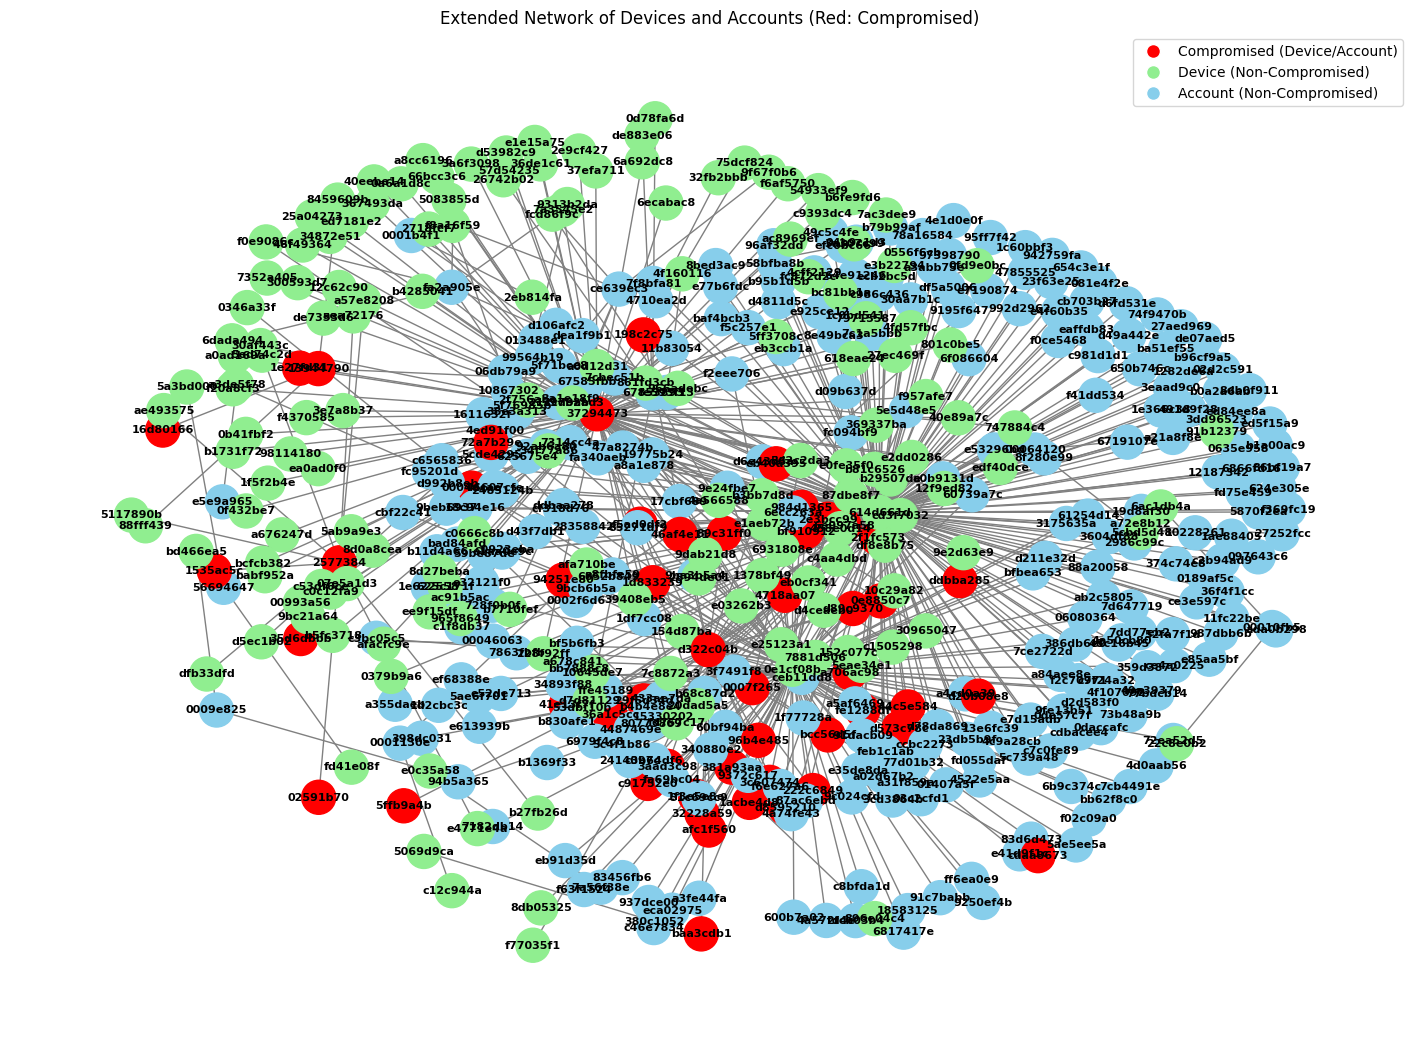

2025-04-28 15:48:59,593 - INFO - Extended compromised network visualization saved


AttributeError: The geopandas.dataset has been deprecated and was removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.

In [1]:
# Fraud Analysis Notebook
# Objective: Investigate cross-bank fraud connections involving a compromised device and user account
# Author: [Your Name]
# Date: April 28, 2025

import pandas as pd
import geoip2.database
from user_agents import parse
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import logging
import numpy as np
import geopandas as gpd
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import pickle

# Set up logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)

# Set up paths
DATA_DIR = Path("data")
NOTEBOOK_DIR = Path("notebooks")
OUTPUT_CSV = DATA_DIR / "enriched_data.csv"
GEOLITE_DB = DATA_DIR / "GeoLite2-City.mmdb"
GEO_CACHE = DATA_DIR / "geo_cache.pkl"

# Ensure directories exist
DATA_DIR.mkdir(exist_ok=True)
NOTEBOOK_DIR.mkdir(exist_ok=True)

def load_data(file_path: str) -> pd.DataFrame:
    """Load Excel data into a DataFrame."""
    try:
        df = pd.read_excel(file_path)
        logger.info(f"Loaded data from {file_path} with {len(df)} records")
        return df
    except FileNotFoundError:
        logger.error(f"File not found: {file_path}")
        return pd.DataFrame()
    except Exception as e:
        logger.error(f"Error loading data: {e}")
        return pd.DataFrame()

def enrich_ip_data(df: pd.DataFrame, ip_column: str) -> pd.DataFrame:
    """Enrich IP addresses with country, city, subnet, and timezone, handling multiple IPs."""
    if not Path(GEOLITE_DB).exists():
        logger.error(f"GeoLite2 database not found at {GEOLITE_DB}")
        return df
    
    reader = geoip2.database.Reader(GEOLITE_DB)
    
    def get_ip_info(ip_str):
        if pd.isna(ip_str):
            return pd.Series({
                "country": None,
                "city": None,
                "subnet": None,
                "timezone": None
            })
        # Handle multiple IPs
        ip_list = str(ip_str).split(",")
        # Use the first valid IP for enrichment
        for ip in ip_list:
            ip = ip.strip()
            try:
                response = reader.city(ip)
                subnet = str(response.traits.network) if response.traits.network else None
                return pd.Series({
                    "country": response.country.name,
                    "city": response.city.name,
                    "subnet": subnet,
                    "timezone": response.location.time_zone
                })
            except Exception as e:
                logger.warning(f"Failed to enrich IP {ip}: {e}")
        # Return None if all IPs fail
        return pd.Series({
            "country": None,
            "city": None,
            "subnet": None,
            "timezone": None
        })
    
    logger.info("Enriching IP data...")
    ip_info = df[ip_column].apply(get_ip_info)
    enriched_df = pd.concat([df, ip_info], axis=1)
    logger.info("IP enrichment completed")
    return enriched_df

def enrich_user_agent(df: pd.DataFrame, ua_column: str) -> pd.DataFrame:
    """Parse User-Agent strings for OS, browser, and device type."""
    def parse_ua(ua):
        if pd.isna(ua):
            return pd.Series({
                "os": None,
                "browser": None,
                "is_mobile": None
            })
        try:
            ua_obj = parse(str(ua))
            return pd.Series({
                "os": ua_obj.os.family,
                "browser": ua_obj.browser.family,
                "is_mobile": ua_obj.is_mobile
            })
        except Exception as e:
            logger.warning(f"Failed to parse User-Agent {ua}: {e}")
            return pd.Series({
                "os": None,
                "browser": None,
                "is_mobile": None
            })
    
    logger.info("Enriching User-Agent data...")
    ua_info = df[ua_column].apply(parse_ua)
    enriched_df = pd.concat([df, ua_info], axis=1)
    logger.info("User-Agent enrichment completed")
    return enriched_df

def find_related_accounts(df: pd.DataFrame, compromised_device: str, compromised_user: str) -> dict:
    """Find accounts linked to compromised device/user via device parameters or location."""
    related = {
        "by_device_id": [],
        "by_device_fingerprint": [],
        "by_ip": [],
        "by_location": []
    }
    
    # Accounts sharing the compromised device
    device_accounts = df[df["device_id"] == compromised_device]["identity"].unique()
    related["by_device_id"] = [acc for acc in device_accounts if acc != "-"]
    logger.info(f"Found {len(related['by_device_id'])} accounts linked by device ID")
    
    # Accounts with same device fingerprint
    try:
        device_fingerprint = df[df["device_id"] == compromised_device]["device_fingerprint"].iloc[0]
        fingerprint_accounts = df[df["device_fingerprint"] == device_fingerprint]["identity"].unique()
        related["by_device_fingerprint"] = [acc for acc in fingerprint_accounts if acc != "-"]
        logger.info(f"Found {len(related['by_device_fingerprint'])} accounts linked by device fingerprint")
    except IndexError:
        logger.warning("No device fingerprint found for compromised device")
    
    # Accounts sharing IPs
    compromised_ips = df[df["identity"] == compromised_user]["ips"].str.split(",", expand=True).stack().str.strip().unique()
    ip_accounts = df[df["ips"].str.contains("|".join(compromised_ips), na=False)]["identity"].unique()
    related["by_ip"] = [acc for acc in ip_accounts if acc != "-"]
    logger.info(f"Found {len(related['by_ip'])} accounts linked by IP")
    
    # Accounts in same city
    try:
        compromised_city = df[df["identity"] == compromised_user]["city"].iloc[0]
        if pd.notna(compromised_city):
            location_accounts = df[df["city"] == compromised_city]["identity"].unique()
            related["by_location"] = [acc for acc in location_accounts if acc != "-"]
            logger.info(f"Found {len(related['by_location'])} accounts linked by city")
        else:
            logger.warning("Compromised user's city is missing")
    except IndexError:
        logger.warning("No city data found for compromised user")
    
    return related

def create_network_visualization(df: pd.DataFrame, related_accounts: dict) -> None:
    """Create a network graph of accounts and devices."""
    G = nx.Graph()
    
    # Add nodes (filter out invalid identities)
    for device in df["device_id"].unique():
        if pd.notna(device):
            G.add_node(device, type="device")
    for account in df["identity"].unique():
        if pd.notna(account) and account != "-":
            G.add_node(account, type="account")
    
    # Add edges
    for _, row in df.iterrows():
        if pd.notna(row["device_id"]) and pd.notna(row["identity"]) and row["identity"] != "-":
            G.add_edge(row["device_id"], row["identity"])
    
    # Highlight compromised nodes
    compromised_nodes = [COMPROMISED_DEVICE, COMPROMISED_USER]
    node_colors = ["red" if node in compromised_nodes else "blue" for node in G.nodes]
    node_sizes = [1000 if node in compromised_nodes else 500 for node in G.nodes]
    
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_color=node_colors,
        node_size=node_sizes,
        font_size=8,
        edge_color="gray"
    )
    plt.title("Network of Devices and User Accounts (Red: Compromised)")
    plt.savefig(NOTEBOOK_DIR / "network_graph.png", dpi=300, bbox_inches="tight")
    plt.show()
    logger.info("Network visualization saved")

def create_extended_compromised_network_visualization(df: pd.DataFrame) -> None:
    """Create a network graph of devices and accounts, highlighting multiple compromised nodes in red."""
    # Define compromised devices based on fraud detection analysis
    compromised_devices = [
        "1535ac5c-8f64-4dd6-a150-80b576b1df54",  # High-risk: multi-country, high IP diversity
        "d322c04b-4a97-40db-8538-f7ca54d5c41d",  # High-risk: multiple identities
        "cdaa8673-164d-44a7-80a0-99cd4cfe3818",  # High-risk: missing identities, high IP diversity
        "02591b70-e8f5-4299-901c-e78b2b79b526",  # Moderate-risk: dual-country
        "16d80166-543b-421f-9d6d-1a38ca25fa8c",  # Moderate-risk: UAE/Russia
        "1e27fd31-779e-4f55-a00a-51f92ffb046d"   # Moderate-risk: resolution discrepancies
    ]
    
    G = nx.Graph()
    label_mapping = {}
    node_types = {}
    
    # Add account nodes
    for account in df["identity"].unique():
        if pd.notna(account) and account != "-":
            # Handle integer and string identities
            if isinstance(account, int):
                short_id = str(account)
            else:
                short_id = account[:8]
            G.add_node(account, type="account")
            label_mapping[account] = short_id
            node_types[account] = "account"
    
    # Add device nodes and edges
    for device_id in df["device_id"].unique():
        if pd.notna(device_id):
            G.add_node(device_id, type="device")
            label_mapping[device_id] = device_id[:8]
            node_types[device_id] = "device"
            # Find accounts associated with this device
            accounts = df[df["device_id"] == device_id]["identity"].unique()
            for account in accounts:
                if pd.notna(account) and account != "-":
                    G.add_edge(device_id, account)
    
    # Determine compromised nodes
    compromised_nodes = set(compromised_devices)
    # Add accounts linked to compromised devices
    for device_id in compromised_devices:
        if device_id in G.nodes():
            for neighbor in G.neighbors(device_id):
                if node_types[neighbor] == "account":
                    compromised_nodes.add(neighbor)
    
    # Assign node colors
    node_colors = []
    for node in G.nodes():
        if node in compromised_nodes:
            node_colors.append("red")  # Compromised nodes
        else:
            node_type = node_types[node]
            node_colors.append("lightgreen" if node_type == "device" else "skyblue")
    
    # Visualization
    plt.figure(figsize=(14, 10))
    pos = nx.spring_layout(G, k=0.3, iterations=50, seed=42)
    nx.draw(
        G,
        pos,
        with_labels=True,
        labels=label_mapping,
        node_color=node_colors,
        node_size=600,
        font_size=8,
        font_weight="bold",
        edge_color="gray"
    )
    
    # Add legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Compromised (Device/Account)', 
               markerfacecolor='red', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Device (Non-Compromised)', 
               markerfacecolor='lightgreen', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Account (Non-Compromised)', 
               markerfacecolor='skyblue', markersize=10)
    ]
    plt.legend(handles=legend_elements, loc="upper right")
    
    plt.title("Extended Network of Devices and Accounts (Red: Compromised)")
    plt.savefig(NOTEBOOK_DIR / "extended_compromised_network.png", dpi=300, bbox_inches="tight")
    plt.show()
    logger.info("Extended compromised network visualization saved")

def create_geo_map_visualization(df: pd.DataFrame) -> None:
    """Create a world map showing device activity locations, with compromised locations in red."""
    # Define compromised devices (same as in create_extended_compromised_network_visualization)
    compromised_devices = [
        "1535ac5c-8f64-4dd6-a150-80b576b1df54",  # High-risk: multi-country, high IP diversity
        "d322c04b-4a97-40db-8538-f7ca54d5c41d",  # High-risk: multiple identities
        "cdaa8673-164d-44a7-80a0-99cd4cfe3818",  # High-risk: missing identities, high IP diversity
        "02591b70-e8f5-4299-901c-e78b2b79b526",  # Moderate-risk: dual-country
        "16d80166-543b-421f-9d6d-1a38ca25fa8c",  # Moderate-risk: UAE/Russia
        "1e27fd31-779e-4f55-a00a-51f92ffb046d"   # Moderate-risk: resolution discrepancies
    ]
    
    # Load or create geocoding cache
    def load_geo_cache():
        if GEO_CACHE.exists():
            with open(GEO_CACHE, "rb") as f:
                return pickle.load(f)
        return {}
    
    def save_geo_cache(cache):
        with open(GEO_CACHE, "wb") as f:
            pickle.dump(cache, f)
    
    geo_cache = load_geo_cache()
    geolocator = Nominatim(user_agent="fraud_analysis_notebook")
    
    def geocode_location(city, country):
        if pd.isna(city) or pd.isna(country):
            return None, None
        location_key = f"{city}, {country}"
        if location_key in geo_cache:
            return geo_cache[location_key]
        try:
            location = geolocator.geocode(location_key, timeout=10)
            if location:
                geo_cache[location_key] = (location.latitude, location.longitude)
                return location.latitude, location.longitude
        except (GeocoderTimedOut, Exception) as e:
            logger.warning(f"Failed to geocode {location_key}: {e}")
        geo_cache[location_key] = (None, None)
        return None, None
    
    # Get unique city-country pairs
    locations = df[["city", "country", "device_id"]].drop_duplicates()
    locations[["latitude", "longitude"]] = locations.apply(
        lambda row: pd.Series(geocode_location(row["city"], row["country"])), axis=1
    )
    
    # Save updated cache
    save_geo_cache(geo_cache)
    
    # Filter out locations without coordinates
    locations = locations.dropna(subset=["latitude", "longitude"])
    if locations.empty:
        logger.error("No valid geocoded locations found. Skipping map visualization.")
        return
    
    # Determine compromised locations
    compromised_locations = locations[locations["device_id"].isin(compromised_devices)]
    compromised_location_keys = set(compromised_locations[["city", "country"]].apply(
        lambda x: f"{x['city']}, {x['country']}", axis=1
    ))
    
    # Assign colors
    locations["color"] = locations.apply(
        lambda x: "red" if f"{x['city']}, {x['country']}" in compromised_location_keys else "blue", axis=1
    )
    
    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(
        locations,
        geometry=gpd.points_from_xy(locations["longitude"], locations["latitude"]),
        crs="EPSG:4326"
    )
    
    # Load world map
    world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
    
    # Plot
    plt.figure(figsize=(15, 10))
    ax = world.plot(color="lightgrey", edgecolor="black", figsize=(15, 10))
    gdf.plot(ax=ax, color=gdf["color"], markersize=50, alpha=0.6)
    
    # Add legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Compromised Location', 
               markerfacecolor='red', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Non-Compromised Location', 
               markerfacecolor='blue', markersize=10)
    ]
    plt.legend(handles=legend_elements, loc="upper right")
    
    plt.title("Geographical Distribution of Device Activity (Red: Compromised)")
    plt.savefig(NOTEBOOK_DIR / "geo_map.png", dpi=300, bbox_inches="tight")
    plt.show()
    logger.info("Geographical map visualization saved")

def create_eda_visualizations(df: pd.DataFrame) -> None:
    """Generate exploratory data analysis visualizations with counts above bars."""
    # Bank distribution
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(data=df, x="bank")
    plt.title("Distribution of Records by Bank")
    plt.xticks(rotation=45)
    # Add counts above bars
    for p in ax.patches:
        ax.text(
            p.get_x() + p.get_width() / 2.,
            p.get_height() + 0.5,
            f"{int(p.get_height())}",
            ha="center",
            va="bottom"
        )
    plt.savefig(NOTEBOOK_DIR / "bank_distribution.png", dpi=300, bbox_inches="tight")
    plt.show()
    
    # Country distribution
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(data=df, x="country")
    plt.title("Distribution of Records by Country")
    plt.xticks(rotation=45)
    # Add counts above bars
    for p in ax.patches:
        ax.text(
            p.get_x() + p.get_width() / 2.,
            p.get_height() + 0.5,
            f"{int(p.get_height())}",
            ha="center",
            va="bottom"
        )
    plt.savefig(NOTEBOOK_DIR / "country_distribution.png", dpi=300, bbox_inches="tight")
    plt.show()
    
    # Device type distribution
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(data=df, x="is_mobile")
    plt.title("Distribution of Device Types")
    plt.xticks([0, 1], ["Desktop", "Mobile"])
    # Add counts above bars
    for p in ax.patches:
        ax.text(
            p.get_x() + p.get_width() / 2.,
            p.get_height() + 0.5,
            f"{int(p.get_height())}",
            ha="center",
            va="bottom"
        )
    plt.savefig(NOTEBOOK_DIR / "device_type_distribution.png", dpi=300, bbox_inches="tight")
    plt.show()
    
    # Missing data analysis
    missing_data = df.isnull().sum()
    logger.info(f"Missing data:\n{missing_data}")
    
    # City data check
    city_counts = df["city"].value_counts(dropna=False)
    logger.info(f"City distribution:\n{city_counts}")

# Main analysis
COMPROMISED_DEVICE = "91b12379-8098-457f-a2ad-a94d767797c2"
COMPROMISED_USER = "0007f265568f1abc1da791e852877df2047b3af9"

# Step 1: Load data
df = load_data(DATA_DIR / "test.xlsx")
if df.empty:
    logger.error("Failed to load data. Exiting.")
    raise SystemExit("Failed to load data.")

# Step 2: Enrich data
df = enrich_ip_data(df, "ips")
df = enrich_user_agent(df, "browser")

# Step 3: Find related accounts
related_accounts = find_related_accounts(df, COMPROMISED_DEVICE, COMPROMISED_USER)
print("Related Accounts:")
for key, accounts in related_accounts.items():
    print(f"{key}: {accounts}")

# Step 4: Visualizations
create_network_visualization(df, related_accounts)
create_extended_compromised_network_visualization(df)
create_geo_map_visualization(df)
create_eda_visualizations(df)

# Step 5: Save enriched data
df.to_csv(OUTPUT_CSV, index=False)
logger.info(f"Enriched data saved to {OUTPUT_CSV}")